## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math

%matplotlib inline

## Helper Functions

In [2]:
class Line:
    """ Class for Line y=mx+b """
    def __init__(self, coords):
        #coords = np.float((coords[0]))
        self.x1 = coords[0]
        self.y1 = coords[1]
        self.x2 = coords[2]
        self.y2 = coords[3]

        self.m = (self.y2 - self.y1) / (self.x2 - self.x1 + np.finfo(float).eps)
        self.b = self.y1 - self.m * self.x1
        
    def __str__(self):
        return np.array2string(self.get_coords())

In [3]:
def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """Applies an image mask"""
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """Out = Initial_img * α + img * β + γ"""
    return cv2.addWeighted(initial_img, α, img, β, γ)

def filter_lines(lines, slope_threshold):
    """ Remove horizontal lines """
    return [l for l in lines if abs(l.m) > slope_threshold]
        
def median_line(lines, y1, y2):
    """ Get Median line segment between [y1, y2]"""
    if lines:
        eps = np.finfo(float).eps
        
        m = np.median([l.m for l in lines])
        b = np.median([l.b for l in lines])

        # Given y, x is found as x=(y-b)/m
        return Line([int((y1-b)/(m + eps)), y1, int((y2-b)/(m + eps)), y2])
    else:
        return Line([0,0,0,0])

def polyfit_line(lines, y1, y2):
    """ Fit line segments to one solid line LSE """
    if lines:
        eps = np.finfo(float).eps
        x, y = [], []
        for l in lines:
            x.extend([l.x1, l.x2])
            y.extend([l.y1, l.y2])
            #x.append(l.x2)
            #y.append(l.y1)
            #y.append(l.y2)
        [m, b] = np.polyfit(x, y, 1)

        # Given y, x is found as x=(y-b)/m
        return Line([int((y1-b)/(m + eps)), y1, int((y2-b)/(m + eps)), y2])
    else:
        return Line([0,0,0,0])

def fit_lines(img, lines):
    """ Fit lines to one solid line """
    lines = filter_lines(lines, 0.5)
    
    # Separate lines with their slope sign
    llines = [l for l in lines if l.m < 0]
    rlines = [l for l in lines if l.m > 0]
    
    # Fit each group to line segment between [y1, y2]
    y1, y2 = int(0.6*img.shape[0]), img.shape[0]
    
    # Method1: Median line
    #solid_lines = [median_line(l, y1, y2) for l in [llines, rlines]]
    # Method2: LSE 
    solid_lines = [polyfit_line(l, y1, y2) for l in [llines, rlines]]
    
    return solid_lines

def draw_lines(img, lines, color=[255, 0, 0], thickness=8, solid=True):
    """ Fit lines to 2 lane and draw over the image """
    if solid is True:
        lines = fit_lines(img, lines)
    for l in lines:
        cv2.line(img, (l.x1, l.y1), (l.x2, l.y2), color, thickness)
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, solid=True):
    """ Returns an image with lane lines drawn """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # Extract lines
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines = [Line(l[0][:]) for l in lines]
    
    # Draw lines
    draw_lines(line_img, lines, solid=solid)
    
    return line_img

## Build a Lane Finding Pipeline



In [4]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def find_lane(img, debug=False):  
    h, w = img.shape[:2]
    img_gray = grayscale(img)
    img_blur = gaussian_blur(img_gray, 3)
    img_edge = canny(img_blur, 50, 150)
    vertices = [[[0.05*w, h], [0.45*w, 0.6*h], [0.55*w, 0.6*h], [0.95*w, h]]]
    img_clipped = region_of_interest(img_edge, np.array(vertices, dtype=np.int))
    img_lanes = hough_lines(img_clipped, 2, np.pi/180, 15, 40, 20)
    img_lanes = weighted_img(img_lanes, img)
    
    if debug is True:
        img_lines = hough_lines(img_clipped, 2, np.pi/180, 15, 40, 20, solid=False)
        plt.rcParams["figure.figsize"] = (25,4)
        fig, axs = plt.subplots(1,5) 
        
        axs[0].imshow(img_blur, cmap = "gray")
        axs[0].set_title('Grayscale blur image')
        axs[1].imshow(img_edge, cmap = "gray")
        axs[1].set_title('Canny edge detection')
        axs[2].imshow(img_clipped, cmap = "gray")
        axs[2].set_title('ROI clipping')
        axs[3].imshow(img_lines)
        axs[3].set_title('Hough line detection result')
        axs[4].imshow(img_lanes)
        axs[4].set_title('Lines fitted to one solid line')
        
    return img_lanes

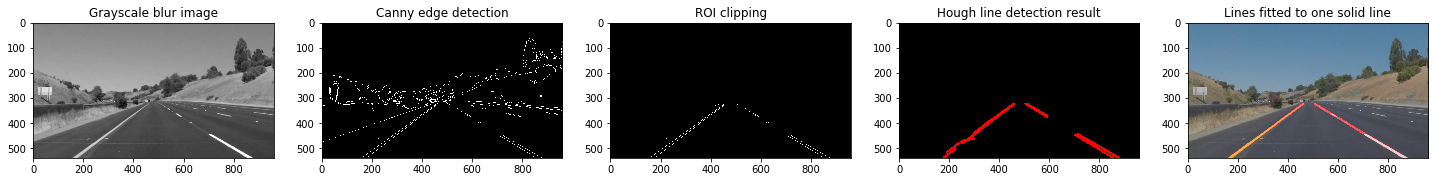

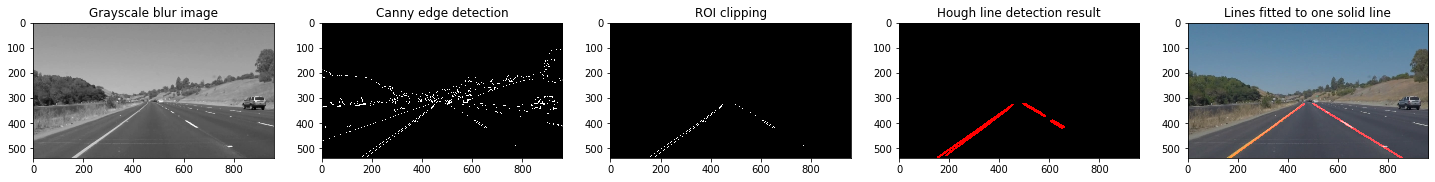

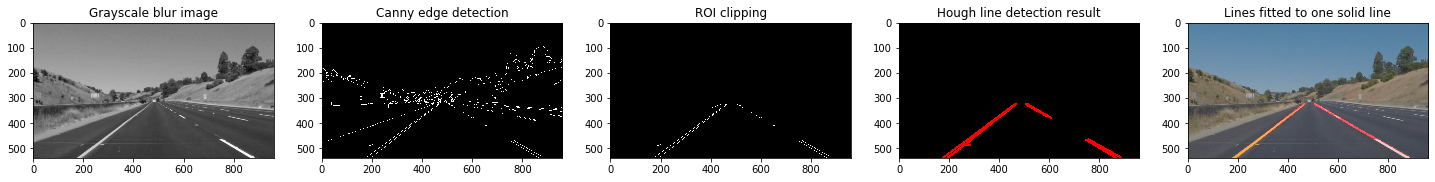

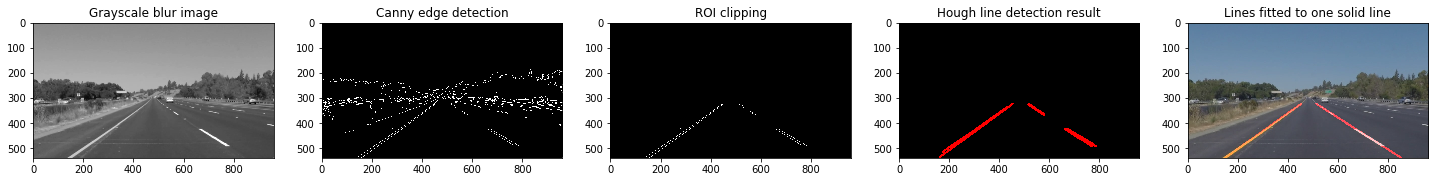

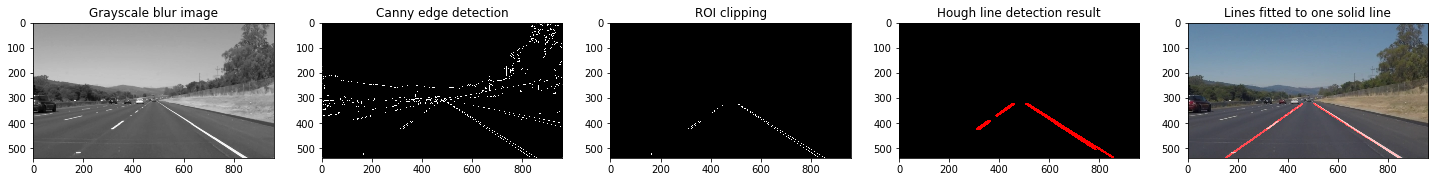

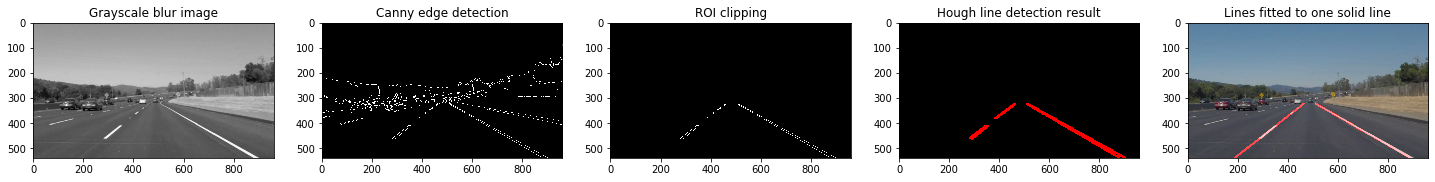

In [5]:
for img_file in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + img_file)
    find_lane(img, debug=True)
plt.show()



## Test on Videos

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
white_output = 'assets/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(find_lane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   5%|▌         | 12/221 [00:00<00:01, 118.93it/s, now=None]

Moviepy - Building video assets/solidWhiteRight.mp4.
Moviepy - Writing video assets/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready assets/solidWhiteRight.mp4
CPU times: user 1.47 s, sys: 526 ms, total: 2 s
Wall time: 2.99 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. 

In [9]:
yellow_output = 'assets/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(find_lane)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▏         | 15/681 [00:00<00:04, 139.41it/s, now=None]

Moviepy - Building video assets/solidYellowLeft.mp4.
Moviepy - Writing video assets/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready assets/solidYellowLeft.mp4
CPU times: user 5.03 s, sys: 1.58 s, total: 6.61 s
Wall time: 11.7 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

In [11]:
challenge_output = 'assets/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(find_lane)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   3%|▎         | 8/251 [00:00<00:03, 71.28it/s, now=None]

Moviepy - Building video assets/challenge.mp4.
Moviepy - Writing video assets/challenge.mp4



Moviepy - Done !
Moviepy - video ready assets/challenge.mp4
CPU times: user 3.41 s, sys: 712 ms, total: 4.13 s
Wall time: 9.33 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Reflection